# 5. Классификация текстов при помощи сетей прямого распространения

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г. 

In [9]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 1. Представление и предобработка текстовых данных 

1.1 Операции по предобработке:
* токенизация
* стемминг / лемматизация
* удаление стоп-слов
* удаление пунктуации
* приведение к нижнему регистру
* любые другие операции над текстом

**Для начала произведем все вышеперечисленные операции:**

In [11]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

from nltk.stem import WordNetLemmatizer 

In [12]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [13]:
list_text = nltk.word_tokenize(text) # токенизируем по словам
list_text

['Select',
 'your',
 'preferences',
 'and',
 'run',
 'the',
 'install',
 'command',
 '.',
 'Stable',
 'represents',
 'the',
 'most',
 'currently',
 'tested',
 'and',
 'supported',
 'version',
 'of',
 'PyTorch',
 '.',
 'Note',
 'that',
 'LibTorch',
 'is',
 'only',
 'available',
 'for',
 'C++']

In [14]:
nltk.sent_tokenize(text) # токенизируем по предложениям

['Select your preferences and run the install command.',
 'Stable represents the most currently tested and supported version of PyTorch.',
 'Note that LibTorch is only available for C++']

In [15]:
stemmer = SnowballStemmer(language = 'english') # приводим слова к единой форме, стемминг опускает окончания слов Snowball Stemmer

In [16]:
stem_list = []
for el in list_text:
  stem_list.append(stemmer.stem(el))
stem_list

['select',
 'your',
 'prefer',
 'and',
 'run',
 'the',
 'instal',
 'command',
 '.',
 'stabl',
 'repres',
 'the',
 'most',
 'current',
 'test',
 'and',
 'support',
 'version',
 'of',
 'pytorch',
 '.',
 'note',
 'that',
 'libtorch',
 'is',
 'onli',
 'avail',
 'for',
 'c++']

In [17]:
nltk.download('wordnet')  # лексическая база данных для английского языка для того, чтобы установить структурированные семантические отношения между словами

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [18]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [19]:
lemmatizer = WordNetLemmatizer() # создаем экземпляр WordNetLemmatizer()

In [20]:
lem_list = []
for el in list_text:
  lem_list.append(lemmatizer.lemmatize(el)) # вызываем функцию lemmatize() для каждого слова в list_text
lem_list

['Select',
 'your',
 'preference',
 'and',
 'run',
 'the',
 'install',
 'command',
 '.',
 'Stable',
 'represents',
 'the',
 'most',
 'currently',
 'tested',
 'and',
 'supported',
 'version',
 'of',
 'PyTorch',
 '.',
 'Note',
 'that',
 'LibTorch',
 'is',
 'only',
 'available',
 'for',
 'C++']

In [21]:
sl = {'stem_word': stem_list, 'norm_word': lem_list} # создаем словарь со словами до и после обработки 
data = pd.DataFrame(sl, index = list_text)
data

,stem_word,norm_word
Select,select,Select
your,your,your
preferences,prefer,preference
and,and,and
run,run,run
the,the,the
install,instal,install
command,command,command
.,.,.
Stable,stabl,Stable


In [22]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
from nltk.corpus import stopwords

In [24]:
stop_words = stopwords.words('english')

In [25]:
stop_words = set(stop_words) # создаем множество с не повторяющимися элементами
words_delete_stop = [ws for ws in list_text if ws not in stop_words] # удаляем стоп-слова
words_delete_stop

['Select',
 'preferences',
 'run',
 'install',
 'command',
 '.',
 'Stable',
 'represents',
 'currently',
 'tested',
 'supported',
 'version',
 'PyTorch',
 '.',
 'Note',
 'LibTorch',
 'available',
 'C++']

In [26]:
# удаляем знаки препинания с помощью регулярного выражения
s = re.sub(r'[^\w\s]','', text)
s

'Select your preferences and run the install command Stable represents the most currently tested and supported version of PyTorch Note that LibTorch is only available for C'

In [27]:
# с помощью модуля string 
import string
string_text = text.translate(str.maketrans('', '', string.punctuation))
string_text

'Select your preferences and run the install command Stable represents the most currently tested and supported version of PyTorch Note that LibTorch is only available for C'

In [28]:
# приводим к нижнему регистру
text.lower()

'select your preferences and run the install command. stable represents the most currently tested and supported version of pytorch. note that libtorch is only available for c++'

Реализовать функцию `preprocess_text(text: str) -> str`, которая:
* приводит строку к нижнему регистру
* заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел


In [29]:
from nltk.tokenize import RegexpTokenizer # Токенизатор, разбивающий строку на подстроки с помощью регулярного выражения

In [30]:
tokenizer = RegexpTokenizer(r'[a-zA-Z]+[\.,!\?]*')

def preprocess_text(text: str) -> str:
  text = text.lower()
  tokens = tokenizer.tokenize(text)
  text = ' '.join(tokens)
  return text

**Проверка**:

In [31]:
print(f'Исходный текст: \n\n{text}')

Исходный текст: 

Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++


In [32]:
print(f'Обработанный текст (замена всех символов, кроме a-z, A-Z и знаков .,!? на пробел): \n\n{preprocess_text(text)}')

Обработанный текст (замена всех символов, кроме a-z, A-Z и знаков .,!? на пробел): 

select your preferences and run the install command. stable represents the most currently tested and supported version of pytorch. note that libtorch is only available for c


1.2 Представление текстовых данных при помощи бинарного кодирования


Представить первое предложение из `text` в виде тензора `sentence_t`: `sentence_t[i] == 1`, если __слово__ с индексом `i` присуствует в предложении.

In [33]:
def process_text(text):
  text = text.lower()
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word.isalpha()] # isalpha() проверка, что строка состоит только из букв
  tokens = [word for word in tokens if not word in stopwords.words()] # не уверена, что надо без стоп-слов, но на всякий случай удалим
  lemmas = [lemmatizer.lemmatize(word) for word in tokens] # приводим слова к базовой форме
  return lemmas

In [34]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [35]:
lemmas = process_text(text)
vocab = dict(zip(set(lemmas), range(len(lemmas)))) # словарь из списка
vocab

{'run': 0,
 'available': 1,
 'note': 2,
 'libtorch': 3,
 'command': 4,
 'tested': 5,
 'represents': 6,
 'currently': 7,
 'stable': 8,
 'preference': 9,
 'select': 10,
 'install': 11,
 'supported': 12,
 'pytorch': 13,
 'version': 14}

In [36]:
text = sent_tokenize(text)[0]
sentence_t = torch.zeros(len(vocab))
for word in process_text(text):
  if word.isalpha() and word.lower() in vocab:
    sentence_t[vocab[lemmatizer.lemmatize(word.lower())]] = 1
sentence_t

tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

Посмотрим, какие слова сюда вошли:

In [37]:
text

'Select your preferences and run the install command.'

In [38]:
process_text(text)

['select', 'preference', 'run', 'install', 'command']

## 2. Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`. 

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)

2.5 Реализовать класс `SurnamesDataset`

2.6. Обучить классификатор.

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

2.1 Считать файл surnames/surnames.csv.

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
surname_df = pd.read_csv('/content/drive/MyDrive/ML_FU/Lab_5_NLP_intro/data/surnames.csv')
surname_df.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


2.2 Закодировать национальности числами, начиная с 0.

In [41]:
label = LabelEncoder()
surname_df["target"] = label.fit_transform(surname_df["nationality"])
print(f"Сlasses: {len(label.classes_)}")
surname_df.head()

Сlasses: 18


,surname,nationality,target
0,Woodford,English,4
1,Coté,French,5
2,Kore,English,4
3,Koury,Arabic,0
4,Lebzak,Russian,14


2.4 Реализовать класс Vocab (токен = символ)

In [42]:
class Vocab:
  def __init__(self, data):
    self.idx_to_token = list({el for word in data for el in word.lower()})
    self.token_to_idx = {j: i for i, j in enumerate(self.idx_to_token)}
    self.vocab_len = len(self.idx_to_token)

In [43]:
vocab = Vocab(surname_df["surname"])
vocab.vocab_len

55

2.5 Реализовать класс SurnamesDataset

In [44]:
class SurnamesDataset(Dataset):
  def __init__(self, data, targets, vocab):
    self.data = data
    self.targets = targets
    self.vocab = vocab

  def vectorize(self, surname):
  #Генерирует представление фамилии surname в при помощи бинарного кодирования (см. 1.2)
    vec = torch.zeros(self.vocab.vocab_len)
    indices = [self.vocab.token_to_idx[el] for el in surname.lower()]
    vec[indices] = 1
    return vec

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.vectorize(self.data[idx]), self.targets[idx]

In [45]:
surname_dataset = SurnamesDataset(
    data=surname_df["surname"].tolist(),
    targets=torch.tensor(surname_df["target"], dtype=torch.long),
    vocab=vocab,
)

2.3 Разбить датасет на обучающую и тестовую выборку

In [46]:
train_size = round(0.8 * len(surname_dataset))
test_size = len(surname_dataset) - train_size
train_df, test_df = random_split(surname_dataset, lengths=(train_size, test_size))
len(train_df), len(test_df)

(8784, 2196)

2.6. Обучить классификатор.

In [47]:
class SurnamesClassifier(nn.Module):

  def __init__(self, in_features, out_features):
    super(SurnamesClassifier, self).__init__()
    self.seq = nn.Sequential(
      nn.Linear(in_features, 256),
      nn.ReLU(),
      nn.Linear(256, out_features),
      nn.LogSoftmax(dim=1),
    )

  def forward(self, inputs):
    return self.seq(inputs)

In [48]:
torch.manual_seed(0)

net = SurnamesClassifier(vocab.vocab_len, vocab.vocab_len)
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_df, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_df, batch_size=512)

In [49]:
if torch.cuda.is_available():
  DEVICE = "cuda"
else:
  DEVICE = "cpu"

In [50]:
def train_func(dataloader, model, loss_fn, optimizer, verbose, device):
  
  model.train()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  avg_loss = 0

  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    pred = model(x)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_loss += loss
    if batch % verbose == 0:
      print(f'loss: {loss:>7f}  [{batch * len(x):>5d} / {size:>5d}]')

    del x, y, pred, loss
    torch.cuda.empty_cache()

  return avg_loss / num_batches

def test_func(dataloader, model, loss_fn, device):
    
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  avg_loss, correct = 0, 0

  for x, y in dataloader:
    x, y = x.to(device), y.to(device)
    pred = model(x)
    avg_loss += loss_fn(pred, y)
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    del x, y, pred
    torch.cuda.empty_cache()

  avg_loss /= num_batches
  accuracy = correct / size
  print(f'Accuracy: {accuracy}, Avg loss: {avg_loss} \n')

  return avg_loss, accuracy

def common(model, loss_fn, optimizer, train_dataloader, epochs, verbose, test_dataloader, device):
    
  train_losses = []
  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "_" * 40)
    train_loss = train_func(train_dataloader, model, loss_fn, optimizer, verbose=verbose, device=device)
    train_losses.append(train_loss.item())
    if test_dataloader:
      test_func(test_dataloader, model, loss_fn, device=device)
    torch.cuda.empty_cache()
  return train_losses

In [51]:
train_losses = common(epochs=20, model=net, loss_fn=loss_fn, optimizer=optimizer, train_dataloader=train_dataloader, test_dataloader=test_dataloader, verbose=300, device=DEVICE)

Epoch 1
________________________________________
loss: 4.060528  [    0 /  8784]
loss: 1.958446  [ 2400 /  8784]
loss: 2.260303  [ 4800 /  8784]
loss: 1.455770  [ 7200 /  8784]
Accuracy: 0.5327868852459017, Avg loss: 1.4695241451263428 

Epoch 2
________________________________________
loss: 1.267261  [    0 /  8784]
loss: 1.814942  [ 2400 /  8784]
loss: 0.914185  [ 4800 /  8784]
loss: 0.861599  [ 7200 /  8784]
Accuracy: 0.5560109289617486, Avg loss: 1.4065418243408203 

Epoch 3
________________________________________
loss: 0.960744  [    0 /  8784]
loss: 1.439323  [ 2400 /  8784]
loss: 1.478016  [ 4800 /  8784]
loss: 1.476469  [ 7200 /  8784]
Accuracy: 0.5819672131147541, Avg loss: 1.3270466327667236 

Epoch 4
________________________________________
loss: 1.314360  [    0 /  8784]
loss: 1.821632  [ 2400 /  8784]
loss: 1.023812  [ 4800 /  8784]
loss: 1.224635  [ 7200 /  8784]
Accuracy: 0.5910746812386156, Avg loss: 1.3021494150161743 

Epoch 5
________________________________________

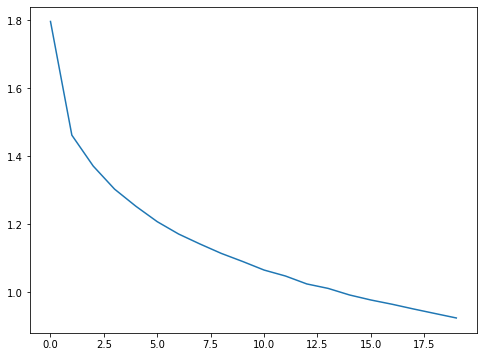

In [52]:
plt.rcParams["figure.figsize"] = (8, 6)
_ = plt.plot(torch.arange(len(train_losses)), train_losses)

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [53]:
test_func(dataloader=test_dataloader, model=net, loss_fn=loss_fn, device=DEVICE);

Accuracy: 0.6434426229508197, Avg loss: 1.1414778232574463 



In [54]:
def total_conclusion(target, surname, model, data, label, n, device):
  x = data.vectorize(surname)
  x = x.to(device)

  pred = model(x.unsqueeze(0))
  pred_prob, pred_label_indices = F.softmax(pred, 1).topk(n, dim=1)
  pred_label = label.inverse_transform(pred_label_indices.squeeze().cpu())

  predict = ", ".join([f'{label} ({prob*100:.1f}%)' for (label, prob) in zip(pred_label, pred_prob.squeeze())])
  print(f'Surname.....{surname}')
  print(f'True........{target}')
  print(f'Predicts....{predict}\n')

In [55]:
students_PI19_3 = [
  "Alexandrova",
  "Baranov",
  "Brusova",
  "Volkova",
  "Gasanova",
  "Danilin",
  "Demenchuk",
  "Egorov",
  "Popova",
  "Polikarpova",
  "Khamikoeva",
]
for surname in students_PI19_3:
    total_conclusion(target="Russian", surname=surname, model=net, data=surname_dataset, label=label, n = 3, device=DEVICE)

Surname.....Alexandrova
True........Russian
Predicts....English (92.8%), French (3.0%), Scottish (1.8%)

Surname.....Baranov
True........Russian
Predicts....Russian (52.9%), Italian (24.0%), Czech (10.9%)

Surname.....Brusova
True........Russian
Predicts....Russian (81.0%), Arabic (6.5%), French (4.2%)

Surname.....Volkova
True........Russian
Predicts....Russian (54.1%), Czech (43.5%), English (1.2%)

Surname.....Gasanova
True........Russian
Predicts....Russian (52.4%), English (23.1%), Italian (9.7%)

Surname.....Danilin
True........Russian
Predicts....English (47.0%), Italian (38.4%), Irish (7.4%)

Surname.....Demenchuk
True........Russian
Predicts....Russian (60.7%), English (11.8%), German (10.9%)

Surname.....Egorov
True........Russian
Predicts....Russian (47.5%), English (24.4%), German (18.2%)

Surname.....Popova
True........Russian
Predicts....Italian (34.0%), Russian (30.8%), Czech (20.3%)

Surname.....Polikarpova
True........Russian
Predicts....Russian (72.4%), Czech (24.5%),

## 3. Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g

3.1 Считать файл `yelp/raw_train.csv`. Оставить от исходного датасета 10% строчек.

3.2 Воспользоваться функцией `preprocess_text` из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

3.3 Разбить датасет на обучающую и тестовую выборку

3.4 Реализовать класс `Vocab` (токен = слово)

3.5 Реализовать класс `ReviewDataset`

3.6 Обучить классификатор

3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)


3.1 Считать файл yelp/raw_train.csv. Оставить от исходного датасета 10% строчек.

In [61]:
reviews = pd.read_csv("/content/drive/MyDrive/ML_FU/Lab_5_NLP_intro/data/raw_train.csv", header=None)
print(len(reviews))
reviews.head(7)

560000


,0,1
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
5,1,Wing sauce is like water. Pretty much a lot of...
6,1,Owning a driving range inside the city limits ...


In [62]:
reviews = reviews.sample(frac=0.1, ignore_index=True, random_state=0)
print(len(reviews))
reviews.head(3)

56000


,0,1
0,2,"Call me crazy, but I really enjoyed this place..."
1,1,"HORRIBLE, HORRIBLE, HORRIBLE ONLINE CUSTOMER S..."
2,2,The staff were extremely helpful in answering ...


3.2 Воспользоваться функцией preprocess_text из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

In [63]:
label = LabelEncoder()

reviews[0] = label.fit_transform(reviews[0])
reviews[1] = reviews[1].apply(lambda x: preprocess_text(x).replace(".", ""))
print(f"classes: {len(label.classes_)}")
reviews.head()

classes: 2


,0,1
0,1,"call me crazy, but i really enjoyed this place..."
1,0,"horrible, horrible, horrible online customer s..."
2,1,the staff were extremely helpful in answering ...
3,1,the steak tartare is fantastic! i d come back ...
4,1,everything i could want for


3.4 Реализовать класс `Vocab` (токен = слово)

In [64]:
class Vocab:
  def __init__(self, data):
    self.idx_to_token = list({word for text in data for word in nltk.word_tokenize(text)} - {"."})
    self.token_to_idx = {j: i for i, j in enumerate(self.idx_to_token)}
    self.vocab_len = len(self.idx_to_token)

In [65]:
vocab = Vocab(reviews[1])
vocab.vocab_len

70409

3.5 Реализовать класс ReviewDataset

In [66]:
class ReviewDataset(Dataset):
  def __init__(self, data, targets, vocab):
    self.data = data
    self.targets = targets
    self.vocab = vocab

  def vectorize(self, review):
    #Генерирует представление отзыва review при помощи бинарного кодирования (см. 1.2)
    vec = torch.zeros(self.vocab.vocab_len)
    indices = [self.vocab.token_to_idx[word] for word in nltk.word_tokenize(review)]
    vec[indices] = 1
    return vec

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.vectorize(self.data[idx]), self.targets[idx]

In [67]:
reviews_dataset = ReviewDataset(data=reviews[1].tolist(), targets=torch.tensor(reviews[0], dtype=torch.long), vocab=vocab)

3.3 Разбить датасет на обучающую и тестовую выборку

In [68]:
train_size = round(0.8 * len(reviews_dataset))
test_size = len(reviews_dataset) - train_size
train, test = random_split(reviews_dataset, lengths=(train_size, test_size))
len(train), len(test)

(44800, 11200)

3.6 Обучить классификатор

In [69]:
class ReviewsClassifier(nn.Module):

    def __init__(self, in_features, out_features):
        super(ReviewsClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, out_features),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, inputs):
        return self.seq(inputs)

In [70]:
torch.manual_seed(0)

net = ReviewsClassifier(vocab.vocab_len, vocab.vocab_len).to(DEVICE)
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test, batch_size=1024)

In [71]:
train_losses = common(epochs=5, model=net, loss_fn=loss_fn, optimizer=optimizer, train_dataloader=train_dataloader, test_dataloader=test_dataloader, verbose=200, device=DEVICE)

Epoch 1
________________________________________
loss: 11.152913  [    0 / 44800]
loss: 0.464431  [12800 / 44800]
loss: 0.482351  [25600 / 44800]
loss: 0.240322  [38400 / 44800]
Accuracy: 0.92125, Avg loss: 0.23961347341537476 

Epoch 2
________________________________________
loss: 0.188663  [    0 / 44800]
loss: 0.124716  [12800 / 44800]
loss: 0.196517  [25600 / 44800]
loss: 0.240620  [38400 / 44800]
Accuracy: 0.9260714285714285, Avg loss: 0.19717006385326385 

Epoch 3
________________________________________
loss: 0.133093  [    0 / 44800]
loss: 0.072733  [12800 / 44800]
loss: 0.118846  [25600 / 44800]
loss: 0.143924  [38400 / 44800]
Accuracy: 0.92625, Avg loss: 0.1961348056793213 

Epoch 4
________________________________________
loss: 0.050833  [    0 / 44800]
loss: 0.092571  [12800 / 44800]
loss: 0.073238  [25600 / 44800]
loss: 0.121696  [38400 / 44800]
Accuracy: 0.9249107142857143, Avg loss: 0.2089570164680481 

Epoch 5
________________________________________
loss: 0.026199  [ 

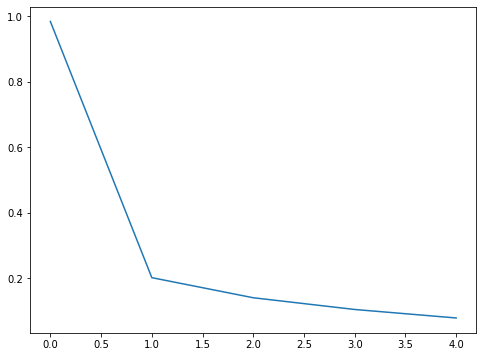

In [72]:
plt.rcParams["figure.figsize"] = (8, 6)
_ = plt.plot(torch.arange(len(train_losses)), train_losses)

In [73]:
test_func(dataloader=test_dataloader, model=net, loss_fn=loss_fn, device=DEVICE)

Accuracy: 0.9241964285714286, Avg loss: 0.22675271332263947 



(tensor(0.2268, grad_fn=<DivBackward0>), 0.9241964285714286)

In [74]:
def total_conclusion(target, review, model, data, label, device):
  x = data.vectorize(review)
  x = x.to(device)

  pred = model(x.unsqueeze(0))
  pred_prob, pred_label_idx = F.softmax(pred, 1).max(dim=1)
  pred_label = label.inverse_transform([pred_label_idx.cpu()])

  print(f'Review.....{review}')
  print(f'True........{target}')
  print(f'Predicts....{pred_label.item()} ({pred_prob.item():.2f}%)\n')

In [77]:
reviews = [
  ("Horrible, horrible, horrible online customer service.", 1),
  ("You can really enjoy this place.", 2),
]
for review, target in reviews:
  total_conclusion(target=target, review=preprocess_text(review).replace(".", ""), model=net, data=reviews_dataset, label=label, device=DEVICE)

Review.....horrible, horrible, horrible online customer service
True........1
Predicts....1 (0.99%)

Review.....you can really enjoy this place
True........2
Predicts....2 (0.55%)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1023: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y = np.asarray(y)
